# Coronavirus - Estimating Case Fatality Ratio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, pickle

from pydemic import Pandemic, Outbreak

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')

### Setup

In [ ]:
coronavirus_confirmed_df = pd.read_csv("../data/clean/coronavirus_confirmed_global.csv", index_col=0)
coronavirus_death_df = pd.read_csv("../data/clean/coronavirus_death_global.csv", index_col=0)
coronavirus_recovered_df = pd.read_csv("../data/clean/coronavirus_recovered_global.csv", index_col=0)

In [ ]:
pandemic = Pandemic("Coronavirus", coronavirus_confirmed_df, coronavirus_death_df, coronavirus_recovered_df)
pandemic.set_smoothing_coefficient(3)
top10_countries = pandemic.get_top_regions(top_n=10, exclude=["United Kingdom", "Iran"])
top20_countries = pandemic.get_top_regions(top_n=20, exclude=["United Kingdom", "Iran"])

## Simple Estimators

In [ ]:
def plot_estimator_curve(outbreak, estimator, **kwargs):
    curve = [estimator(outbreak, t) for t in range(outbreak.duration)]
    
    plt.plot(curve, label=outbreak.region, **kwargs)
    
    return 0

### Naive CFR

This is the simplest CFR estimator. It uses aggreate data of fatalities and cases at a given point in time.

In [ ]:
def nCFR(outbreak, t):
    if t > outbreak.duration:
        return np.nan
    
    return outbreak.cumulative_fatality_curve[t] / outbreak.cumulative_epidemic_curve[t]

In [ ]:
pandemic.apply(plot_estimator_curve, nCFR, regions=top10_countries)
plt.legend()
plt.show()

### Outcome-controlled Naive CFR

As seen on [2005 Guani](http://localhost:8888/notebooks/nbs/literature_review.ipynb#Methods-for-Estimating-the-Case-Fatality-Ratio-for-a-Novel,-Emerging-Infectious-Disease), this estimator will control for the censored data by only considering the resolved cases. 

A **resolved** case is one that has a known outcome of either *death* or *recovery*, whereas an **active** case is one for which no event has occured as of given time period $t$ (therefore, right-censored).

Therefore, the first assumption for this estimator is that the CFR for active cases will be similar in distribution than that of resolved cases.

Furthermore, another assumption that needs to be met for this estimator to work well is that "the hazards of death and recovery at any time $k$ from onset, conditional on an event occuring at time $k$, are proportional".

In [ ]:
def outcome_controlled_nCFR(outbreak, t):
    if t > outbreak.duration:
        return np.nan
    
    return outbreak.cumulative_fatality_curve[t] / (outbreak.cumulative_recovery_curve[t] + outbreak.cumulative_fatality_curve[t])

In [ ]:
pandemic.apply(plot_estimator_curve, outcome_controlled_nCFR, regions=top10_countries)
plt.legend()
plt.show()

### Parametric Mixture Models

As seen on [2005 Guani](http://localhost:8888/notebooks/nbs/literature_review.ipynb#Methods-for-Estimating-the-Case-Fatality-Ratio-for-a-Novel,-Emerging-Infectious-Disease). This seems powerful, yet cannot be applied to our case as we are missing patient level data.

### Underestimate-Corrected Support

In [ ]:
from scipy.optimize import fsolve
from scipy.special import gamma

# this distribution is useful as a baseline for the potential parameters we will encounter
# based on some paper
def estimate_weibull_parameters(mu=8.9, std=5.4, k_0=1):
    def optimization_problem(k):
        return (std / mu)**2 - (gamma(1+ 2/k) / gamma(1+ 1/k)) ** 2 + 1;

    # solve for k
    k = fsolve(optimization_problem, k_0)[0]   
    # solve for lambda
    l = mu / gamma(1 + 1/k) 
    
    return k, l

k, l = estimate_weibull_parameters()

In [ ]:
def known_outcome_adjusted_CFR(outbreak, t):
    case_density = outbreak.epidemic_curve[:t]
    resolved_case_rate = outbreak.resolved_case_rate[:t]
    
    result = 0
    
    for i in range(t):
        for j in range(i + 1):
            result += case_density[i - j] * resolved_case_rate[j]
            
    known_outcome_coefficients = result / case_density.sum()
    
    return known_outcome_coefficients * nCFR(outbreak, t)

In [ ]:
pandemic.apply(plot_estimator_curve, known_outcome_adjusted_CFR, regions=["France", "US", "Germany", "Belgium"])
plt.legend()
plt.show()

### Hazard Rate Generation

In [ ]:
from scipy.stats import weibull_min

def generate_hazard_rate(k, l, ppf_end=0.99):
    W = weibull_min(k, scale=l)
    K = int(W.ppf(ppf_end))
    
    x = np.arange(K)
    
    fatality_rate = W.pdf(x)
    cumulative_fatality_rate = W.cdf(x)
    
    hazard_rate = np.zeros(K)
    hazard_rate[0] = fatality_rate[0]
    hazard_rate[1:K] = fatality_rate[1:K] / (1 - cumulative_fatality_rate[:K-1])

    return hazard_rate

def survival_function(t, hazard_rate):
    if t > hazard_rate.shape[0]:
        raise Exception("bad arg") 
    
    return np.exp(-hazard_rate[:t].sum())

In [599]:
# creates a random matrix and compares it to the hazard function for each column.
# if any "tests" fail, the period after confirmed report is saved, otherwise, a -1 is placed there to signify a recovery
def simulate_cases(n_cases, fatality_hazard_rate, recovery_probability):
    K = fatality_hazard_rate.shape[0]
    
    probability_samples = np.random.rand(n_cases, K)
    
    recovery_outcomes = np.argmax(probability_samples[:, :] < recovery_probability, axis=1)
    fatality_outcomes = np.argmax(probability_samples[:, :] < fatality_hazard_rate, axis=1)
    
    # assumption: if fatality/recovery occurs the same day, the fatality takes precendence
    fatality_bitmask = fatality_outcomes <= recovery_outcomes
    
    outcome_days = np.minimum(fatality_outcomes, recovery_outcomes)
    
    return outcome_days, fatality_bitmask
    
def simulate_outcomes(cases, hazard_rate, recovery_probability, n_sims=100):
    T = cases.shape[0]
    K = hazard_rate.shape[0]
    
    fatalities = np.zeros((n_sims, T))
    recoveries = np.zeros((n_sims, T)) 
    
    for t, n_cases in enumerate(cases.astype(int)):
        outcome_days, fatality_bitmask = simulate_cases(int(n_cases * n_sims), hazard_rate, recovery_probability)
        
        for sim in range(n_sims):
            sim_outcome_days = outcome_days[n_cases * sim: n_cases * (sim + 1)]
            sim_fatality_bitmask = fatality_bitmask[n_cases * sim: n_cases * (sim + 1)]
            
            deaths_per_day = np.bincount(sim_outcome_days[sim_fatality_bitmask])
            censoring = min(deaths_per_day.shape[0], T - t)
            
            fatalities[sim, t:(t + censoring)] += deaths_per_day[:censoring]
            
            recoveries_per_day = np.bincount(sim_outcome_days[~sim_fatality_bitmask])
            censoring = min(recoveries_per_day.shape[0], T - t)
            
            recoveries[sim, t:(t + censoring)] += recoveries_per_day[:censoring]
            
    return fatalities, recoveries

### Fatality Curve Estimate

In [600]:
def estimate_fatality_curve(cases, hazard_density):
    T = len(cases)
    K = len(hazard_density)
    
    estimate = np.zeros(T)
    
    cumulative_survival_rate_distribution = (1 - hazard_rate_distribution).cumprod()
    
    estimate[0] = cases[0] * hazard_rate_distribution[0]
    
    for t in range(1, T):
        autoregressive_start = max(1, t-K + 1)
        
        for i in range(autoregressive_start, t):
            estimate[t] += epidemic_curve[i] * hazard_rate_distribution[t-i] * cumulative_survival_rate_distribution[t-i]
            
    return estimate

### Distance Metrics

In [601]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def dtw(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    
    return distance

def norm(x, y):
    return np.linalg.norm(x - y)

def max_cumulative(x, y):
    T = len(x)
    cumx = x.cumsum()
    cumy = y.cumsum()
    return max(abs(cumx[t] - cumy[t]) for t in range(T))

def mean_cumulative(x, y):
    T = len(x)
    cumx = x.cumsum()
    cumy = y.cumsum()
    return sum(abs(cumx[t] - cumy[t]) for t in range(T)) / T

In [ ]:
class HazardModel:
    def __init__(self, outbreak, distance=norm):
        self.region = outbreak.region
        self.n = outbreak.smooth_epidemic_curve.values
        self.x = outbreak.smooth_fatality_curve.values
        
        self.distance = distance
        
    def evaluate_hazard_rate(self, r, p, K):
        if p == 0: return np.inf
        
        h = generate_hazard_rate_distribution(r, p, K=K)
        
        x_hat = estimate_fatality_curve(self.n, h)
        
        return self.distance(self.x, x_hat)
    
    def plot_estimate(self, r, p, K):
        ax = plt.gca()
        
        plt.title(f"Hazard Model - {self.region} - {self.distance}")
        
        h = generate_hazard_rate_distribution(r, p, K=K)
        x_hat = estimate_fatality_curve(self.n, h)
        
        plt.plot(self.x, label="x")
        plt.plot(x_hat, label="x_hat")
        
        plt.legend()
        
        plt.show()
        

## Optimization

In [ ]:
import itertools
from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
r_space = np.arange(2, 30)
p_space = np.linspace(1, 0, 100, endpoint=False)
K_space = np.arange(2, 40)

### Grid Search

In [ ]:
def grid_search(model, r_space, p_space, K_space):
    r_bar = master_bar(r_space)
    p_bar = progress_bar(p_space, parent=r_bar)
    
    minimum_distance = None
    minimum_parameters = None

    for r in r_bar:
        for p in p_bar:
            for K in K_space:
                distance = model.evaluate_hazard_rate(r, p, K)

                if minimum_distance is None or minimum_distance > distance:
                    minimum_distance = distance
                    minimum_parameters = (r, p, K)

                r_bar.child.comment = f'distance={distance}'

        r_bar.main_bar.comment = f"best_params={minimum_parameters}, minimum_distance={minimum_distance}"

    return minimum_parameters, minimum_distance

### Bayesian Optimization

In [602]:
from bayes_opt import BayesianOptimization

In [617]:
outbreak = pandemic.outbreaks["Germany"]

In [618]:
def mean_cumulative_absolute_distance(cumulative_realization, simulations):
    T = cumulative_realization.shape[0]
    cumulative_simulations = simulations.cumsum(axis=1)
    
    return np.mean(np.abs(cumulative_simulations - cumulative_realization[:, np.newaxis].T))

In [619]:
def run(k, l, r):
    h = generate_hazard_rate(k, l)
    fatalities, recoveries = simulate_outcomes(outbreak.epidemic_curve, h, r)
    
    return - mean_cumulative_absolute_distance(outbreak.cumulative_fatality_curve, fatalities)

In [620]:
# Bounded region of parameter space
pbounds = {'k': (1, 1.8), 'l': (11, 14), 'r': (0.15, 0.5)}

optimizer = BayesianOptimization(
    f=run,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=30,
)

|   iter    |  target   |     k     |     l     |     r     |
-------------------------------------------------------------
|  1        | -9.443e+0 |  1.334    |  13.16    |  0.15     |
|  2        | -9.354e+0 |  1.242    |  11.44    |  0.1823   |
|  3        | -5.201e+0 |  1.149    |  12.04    |  0.2889   |
|  4        | -2.109e+0 |  1.301    |  13.37    |  0.4211   |
|  5        | -5.956e+0 |  1.426    |  13.36    |  0.2112   |
|  6        | -2.254e+0 |  1.477    |  11.78    |  0.4114   |
|  7        | -2.26e+03 |  1.182    |  11.47    |  0.4816   |
|  8        | -5.316e+0 |  1.581    |  13.19    |  0.2181   |
|  9        | -3.787e+0 |  1.376    |  12.27    |  0.3152   |
|  10       | -2.682e+0 |  1.764    |  12.99    |  0.3148   |


In [614]:
best_params = optimizer.max["params"]

best_params

{'k': 1.156937432220853, 'l': 12.429343784489696, 'r': 0.4057687057183451}

In [615]:
h = generate_hazard_rate(best_params["k"], best_params["l"])

fatalities, recoveries = simulate_outcomes(outbreak.epidemic_curve, h, best_params["r"], n_sims=100)

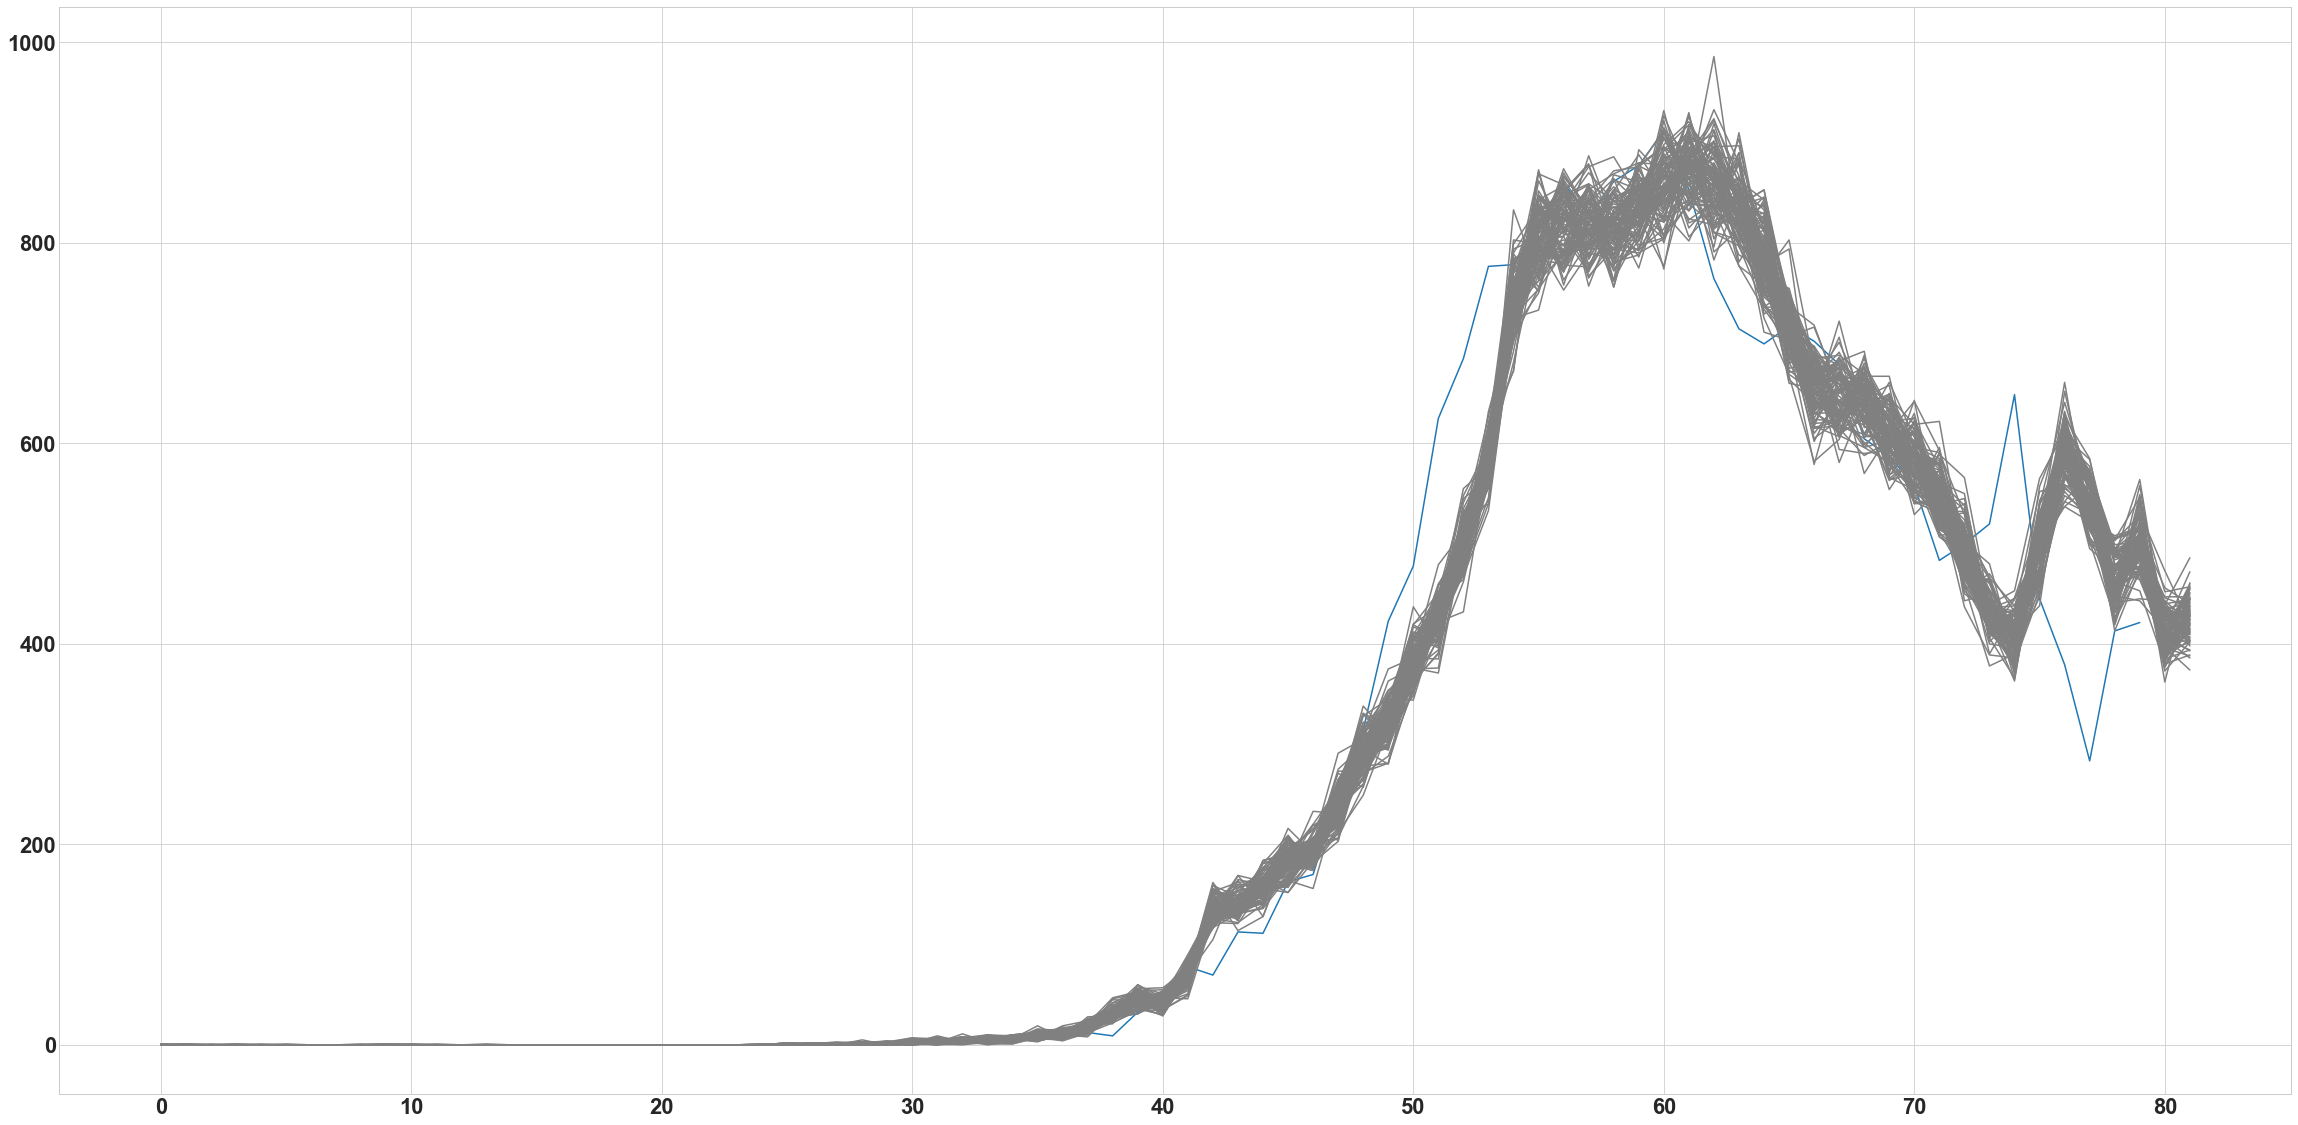

In [616]:
plt.plot(outbreak.smooth_fatality_curve.values)
plt.plot(fatalities.T, c='grey')
plt.show()

### Country Best Parameteres

In [578]:
italy_best_parameters = {'k': 1.5680800271994926, 'l': 13.459646608653848, 'r': 0.27727495101632926}
france_best_parameters = {'k': 1.5932391692362207, 'l': 13.595494436079711, 'r': 0.2527648604733469}
spain_best_parameters = {'k': 1.156937432220853, 'l': 12.429343784489696, 'r': 0.4057687057183451}

# Archive

### Naive CFR

Firstly, we can analyze the most recent Naive CFR values. We can use these initial values to create a search range for our estimator. We consider both the global distribution as well as the one considering only the top 10 countries.

In [579]:
most_recent_cfr = global_coronavirus_outbreak.cfr_curve.iloc[-1]

pd.DataFrame({"World": most_recent_cfr.describe(), "Top10": most_recent_cfr[coronavirus_top10_countries].describe()})

NameError: name 'global_coronavirus_outbreak' is not defined

As we can see above, using all countries greatly reduces the mean and quartile values of CFR. This makes sense as a lot of countries are yet to hit their peak of the infection, and so their current CFR is an underestimation of what it will eventually reach (mostly due to the lag between diagnosis and outcome + the pile-on effects of exhausted health service resources).

#### First-death-adjusted CFR

We can notice that the Naive CFR estimator varies a lot in the early stages and begins to steadily grow as the epidemic develops (towards a flatenning at different levels).

In [ ]:
# fetch first death time lags from global death df
first_death_time_lags = global_death_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))

ax = plt.gca()
k=1

for country in coronavirus_top10_countries:
    cumulative_country_df = global_coronavirus_outbreak.get_region_df(country).cumsum(axis=0)
    
    first_death_in_country = first_death_time_lags[country]
    corrected_cumulative_country_df = cumulative_country_df.loc[first_death_in_country:, :].reset_index(drop=True)
    
#     (corrected_country_df.loc[:, "Dead"].cumsum() / corrected_country_df.loc[:, "Infected"].cumsum()).rolling(k).mean().plot(ax=ax, label=country)

    (corrected_cumulative_country_df["Dead"] / corrected_cumulative_country_df["Infected"]).rolling(k).mean().plot(ax=ax, label=country)
    
plt.legend()

ax.set_xlabel("CFR")
ax.set_xlabel("days since first death")

global_coronavirus_outbreak.add_plot_details(ax, f"Naive CFR - MA={k} days")

### Individual epidemic study

First, we want to convert our indices to time deltas to facilitate manipulation.

In [ ]:
# find first day that confirm cases aren't 0 for every country
first_confirmed_case_time_lags = global_confirmed_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))

In [ ]:
for country in global_coronavirus_outbreak.regions:
    country_df = global_coronavirus_outbreak.get_region_df(country)
    
    first_confirmed_case_in_country = first_confirmed_case_time_lags[country]
    corrected_country_df = country_df.loc[first_confirmed_case_in_country - pd.Timedelta(days=1):, :]
    
    corrected_country_df.loc[:, "CFR"] = corrected_country_df.loc[:, "Dead"] / corrected_country_df.loc[:, "Infected"]
    
    corrected_country_df.to_csv(f"../data/countries/{country}.csv", index=None)

### US

In [ ]:
us_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') \
                    .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key"], axis=1).groupby('Province_State').sum().transpose()
us_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')\
                .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key", "Population"], axis=1).groupby('Province_State').sum().transpose()

In [ ]:
us_coronavirus_outbreak = Outbreak("us_coronavirus")

us_coronavirus_outbreak.set_epidemic_curve(us_confirmed_df)
us_coronavirus_outbreak.set_fatality_curve(us_death_df)

us_coronavirus_outbreak.convert_indices_to_timedelta_since_epidemic_start_date()

In [ ]:
us_coronavirus_outbreak.filter_top_regions()

In [ ]:
top_regions_total_number_of_cases = us_coronavirus_outbreak.epidemic_curve.sum(axis=1)[-1]
us_total_number_of_cases = us_coronavirus_outbreak.base_epidemic_curve.sum(axis=1)[-1]

top_regions_total_number_of_deaths = us_coronavirus_outbreak.fatality_curve.sum(axis=1)[-1]
us_total_number_of_deaths = us_coronavirus_outbreak.base_fatality_curve.sum(axis=1)[-1]

print("Case coverage=%.2f" % ((top_regions_total_number_of_cases / us_total_number_of_cases) * 100))
print("Death coverage=%.2f" % ((top_regions_total_number_of_deaths / us_total_number_of_deaths) * 100))

We should remove those regions not yet affected by the pandemic.

In [ ]:
ax = plt.gca()

us_coronavirus_outbreak.cfr_curve.fillna(0).plot(ylim=[-0.01, 0.1], ax=ax)

us_coronavirus_outbreak.add_plot_details(ax, "cfr_curve")